In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from emukit.core import ContinuousParameter, ParameterSpace
import GPy
import math
import time

print("lib success")

lib success


In [2]:
from copy import deepcopy


rf = pickle.load(open("./rf_surrogate_cnn.pkl", "rb"))
cost_rf = pickle.load(open("./rf_cost_surrogate_cnn.pkl", "rb"))

def objective_function(x, epoch=40):
    """
    Function wrapper to approximate the validation error after N epochs of the hyperparameter configurations
    x by the prediction of a surrogate regression model, which was trained on the validation error of 
    randomly sampled hyperparameter configurations.
    """
    
    # normalize all hyperparameter to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = rf.predict(x_norm[None, :])[0]

    return y

def runtime(x, epoch=40):
    """
    Function wrapper to approximate the training time of the hyperparameter configurations x.
    """
    
    # normalize all hyperparameter to be in [0, 1]
    x_norm = deepcopy(x)
    x_norm[0] = (x[0] - (-6)) / (0 - (-6))
    x_norm[1] = (x[1] - 32) / (512 - 32)
    x_norm[2] = (x[2] - 4) / (10 - 4)
    x_norm[3] = (x[3] - 4) / (10 - 4)
    x_norm[4] = (x[4] - 4) / (10 - 4)
    

    x_norm = np.append(x_norm, epoch)
    y = cost_rf.predict(x_norm[None, :])[0]

    return y

print("cell two success")

cell two success


# Bayesian optimization

In [3]:

list_params = []
list_params.append(ContinuousParameter("learning_rate",-6, -1))
list_params.append(ContinuousParameter("batch_size",32, 512))
list_params.append(ContinuousParameter("n_filters_1", 4, 10))
list_params.append(ContinuousParameter("n_filters_2", 4, 10))
list_params.append(ContinuousParameter("n_filters_3", 4, 10))

space = ParameterSpace(list_params)

print("append all ok girl")

append all ok girl


## Initial Design

In [4]:
from emukit.experimental_design.model_free.random_design import RandomDesign
from emukit.core import ParameterSpace, ContinuousParameter

n_init = 2


# TODO: draw n_init configurations randomly 
design = RandomDesign(space)
X_init = design.get_samples(n_init)
Y_init = []

for config in X_init: 
    Y_init.append([objective_function(config)])
    
# TODO: evaluate all configurations and store them 
X_init = np.array(X_init)
Y_init = np.array(Y_init)


print(X_init)

[[ -5.85853389 203.11703367   8.16146479   6.29794738   7.37673112]
 [ -2.30278075  76.143108     6.52145146   5.4243798    8.52719576]]


## BO components

In [5]:
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.core.optimization import AcquisitionOptimizer

kernel = GPy.kern.Matern52(X_init.shape[1], ARD=True)
gp = GPyModelWrapper(GPy.models.GPRegression(X_init, Y_init, kernel, noise_var=1e-10))
ei = ExpectedImprovement(gp)
optimizer = AcquisitionOptimizer(space)

## BO loop

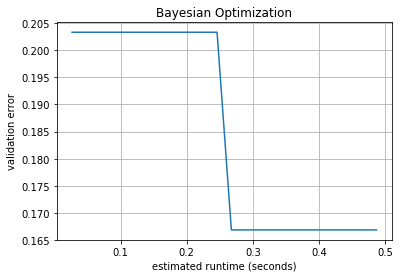

In [6]:
n_iters = 20

incumbent_trajectory = []  # keeps track of the incumbent after each iterations
runtime_trajectory = []   # saves the runtime after each interation
t = 0
current_incumbent = 1

zero_time = time.time()
for i in range(n_iters):
    
    # TODO: optimize acquisition function   
    optimizer = AcquisitionOptimizer(space)
    x_new, _ = optimizer.optimize(ei)    
    
    # TODO: evaluate objective function and estimate the training time
    y_new = objective_function(x_new[0])   
    
    # TODO: augment data with new observations and update the model
    X = np.append(X_init, x_new, axis=0)
    Y = np.append(Y_init, y_new)    
    
    # TODO: bookkeeping of the incumbent and the runtime
    runtime_trajectory.append(time.time() - zero_time )  
    
    if Y.min() < current_incumbent:
        current_incumbent = Y.min()        
    incumbent_trajectory.append(current_incumbent)
   
# PLOT STUFF
plt.plot(runtime_trajectory, incumbent_trajectory)
plt.xlabel("estimated runtime (seconds)")
plt.ylabel("validation error")
plt.grid(True)
plt.title("Bayesian Optimization")
plt.show()


# Hyperband

In [7]:
def get_random_hyperparameter_configuration():
    rd = RandomDesign(space)
    return RandomDesign.get_samples(rd, 1)
print("HB check")

HB check


In [8]:
def successive_halving(n, r, s):
    """
    Run one iteration of successive halving
    :param n: initial number of hyperparameter configurations
    :param r: initial number of iterations 
    :param s: defines the tradeoff between r and n
    """
    global best_loss
    global best_config   
    T = [ get_random_hyperparameter_configuration()[0] for i in range(n) ] 
    for i in range(s+1):
        val_losses = []
        # TODO compute the number of configs n_i and epochs r_i
        n_i = n*eta**(-i)
        r_i = r*eta**(i)
        print("conf numb")
        print(n_i)
        print(r_i)
        
        # TODO run all n_i configuration for r_i epochs 
        val_losses = [ objective_function(get_random_hyperparameter_configuration()[0], epoch=r_i) for t in T ]

        # PLOT    
        plt.scatter(np.ones(len(val_losses)) * r_i, val_losses)
        
        T = [ T[i] for i in np.argsort(val_losses)[0:int( n_i/eta )] ]
        # TODO: keep only the best n_i/eta configurations
        
        if (np.min(val_losses) < best_loss):
            best_loss = np.min(val_losses)
    
        print("Best loss: ", best_loss)
        plt.scatter(np.ones(len(val_losses)) * r_i, val_losses)
        

3
conf numb
27
1.4814814814814814
Best loss:  0.42339497665689485
conf numb
9.0
4.444444444444445
Best loss:  0.25373606243399
conf numb
3.0
13.333333333333332
Best loss:  0.25373606243399
conf numb
1.0
40.0
Best loss:  0.16900617422475034


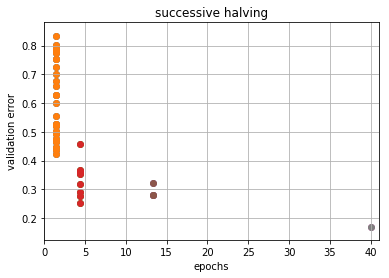

conf numb
9
4.444444444444445
Best loss:  0.16900617422475034
conf numb
3.0
13.333333333333334
Best loss:  0.16900617422475034
conf numb
1.0
40.0
Best loss:  0.16900617422475034


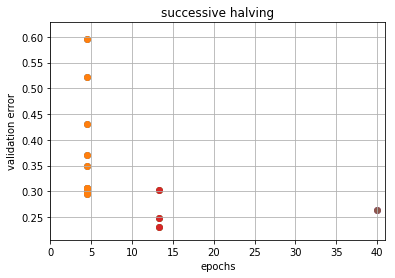

conf numb
6
13.333333333333332
Best loss:  0.16900617422475034
conf numb
2.0
40.0
Best loss:  0.16900617422475034


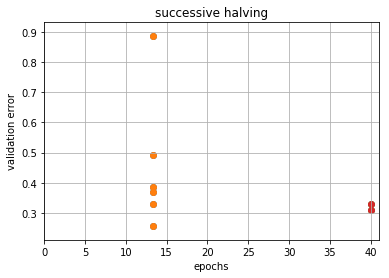

conf numb
4
40
Best loss:  0.16900617422475034


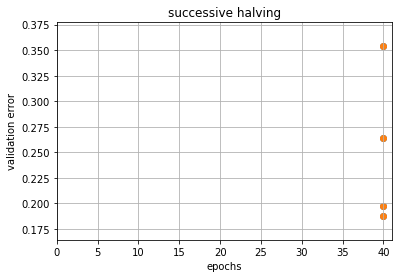

In [9]:
best_loss = 1
best_config = []

max_iter = 40  # maximum iterations/epochs per configuration
eta = 3 # defines downsampling rate (default=3)
s_max = int(np.log(max_iter)/np.log(eta))  # number of unique executions of Successive Halving (minus one)
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)
print(s_max)
for s in reversed(range(s_max+1)):
    n = int(np.ceil(int(B/max_iter/(s+1))*eta**s)) 
    r = max_iter*eta**(-s)
    # TODO: compute initial number of configurations and initial number to run configurations for
    
    # run successive halving
    successive_halving(n, r, s)
    plt.xlabel("epochs")
    plt.ylabel("validation error")
    plt.grid(True)
    plt.title("successive halving")
    plt.xlim(0, 41)
    plt.show()

# Combining Bayesian optimization with Hyperband

In [10]:
# did not do